# SGNS Embedding Solvers

In [ ]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.5.0-spark2.1-s_2.11,com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext, Row, Window
from pyspark.sql.types import *
import pyspark.sql.functions as func
sqlContext = SQLContext(sc)

from pyspark.ml.feature import Word2Vec
from pyspark.mllib.linalg.distributed import CoordinateMatrix

from nltk.tokenize import word_tokenize
from nltk.util import bigrams, ngrams

from datetime import datetime as dt
from operator import add

import gcsfs
import re
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

sc.setCheckpointDir("gs://fin-bucket/tmp/")

## Prepare the corpus

We use English wiki as out corpus. The data is freely available to download and comes in XML files, which were processed using wiki extractor (a software package that can be found here https://github.com/attardi/wikiextractor) to extract the text from the articles. The extracted text from articles are written to documents are then stored in HDFS.

In [ ]:
fpath = "hdfs:///wiki/"

paths = ",".join([f"{fpath}{folder}/wiki_{file:0>2}" 
                  for folder in {"AA"}#, "AB", "AC", "AD"} 
                  for file in range(100)])
#paths += "," + ",".join([f"{fpath}AE/wiki_{file:0>2}" for file in range(18)])

rdd = sc.textFile(paths)
rdd.take(10)

['<doc id="3943092" url="https://en.wikipedia.org/wiki?curid=3943092" title="Let\'s Get It: Thug Motivation 101">',
 "Let's Get It: Thug Motivation 101",
 '',
 'Let\'s Get It: Thug Motivation 101 is the major label debut studio album by American rapper Young Jeezy. It was released on July 26, 2005, by his indie record label Corporate Thugz, under the distribution from Def Jam. On the UK\'s album release, it features the remixed version of "Go Crazy", featuring guest appearance from rapper Jay-Z.',
 '',
 'The album was supported by 4 singles: "And Then What" featuring Mannie Fresh, "Soul Survivor" featuring Akon, "Go Crazy" and "My Hood".',
 '',
 'The album debuted at #2 on the "Billboard" 200, selling 172,000 copies in the first week. On September 29, 2005, the album was certified Platinum by the Recording Industry Association of America (RIAA).',
 '',
 'In 2015, hip hop writer Brooklyn Russell declared the album "trap rap\'s apotheosis" while observing its impact: "Working with only a

The corpus is cleaned by removing the article tags, any punctuation or numbers, before we split into tokenized sentences. Exactly how best to produce the data is dependent on the task at hand; we will leave in stop words for now. Details of this will be discussed in the report.

In [ ]:
def filter_func(x):
    try:
        return x[0]!="<"
    except:
        return False
    
table = str.maketrans('', '', string.punctuation)

tokenize = lambda x: [w.lower().translate(table) for w in word_tokenize(x) if w.isalpha()]
    
corpus = rdd.filter(filter_func)\
            .flatMap(lambda x: x.split(" . "))\
            .map(tokenize)

## SparkML Word2Vec

In order to use SparkML's built-in Word2Vec SGNS implementation we must have our data in DataFrame form. We can then fit the model: we use embedded vectors of size 300 and a window size of 2 either side of the target word. 

In [ ]:
doc = corpus.map(Row).toDF(["sentence"])

In [ ]:
t0 = dt.nowutc()
word2Vec = Word2Vec(vectorSize=300, windowSize=2, seed=42, 
                    inputCol="sentence", outputCol="model")

model = word2Vec.fit(doc)
t1 = dt.nowutc()
#model.save("gs://fin-bucket/nwe/w2v_1")

In [ ]:
print(f"Computation time for fitting:\n{t1-t0:>7.1f}s")

Computation time for fitting:
2302.4s


## Prepare the corpus 

We will prepare the corpus by extracting the word-context pairs, $D$, fitering out infrequent terms and coding as integers. The coded pairs are written to CSV for the TensorFlow models to read.

In [ ]:
# collect infrequent words onto the driver node as it's a relatively small vector
infrequent = corpus.flatMap(lambda x: [(e, 1) for e in x])\
                   .reduceByKey(add)\
                   .filter(lambda x: x[1] < 20)\
                   .map(lambda x: x[0]).collect()
infrequent = set(infrequent)

In [ ]:
print(f"number of words filtered out:", len(infrequent))

number of words filtered out: 241431


In [ ]:
def filter_func(x):
    return not any(i in infrequent for i in x)

In [ ]:
def ngram2pairs(x):
    x = list(x)
    w = x.pop(2)
    return [(w, c) for c in x]

# prepare the word-context pairs vocabulary D
D = corpus.flatMap(lambda x: list(ngrams(x, 5)))\
          .filter(filter_func)\
          .flatMap(ngram2pairs)
          
# collect the distinct vocabulary so we can swap words with numbers
w2i = D.map(lambda x: x[1]).distinct()\
       .collect()

D = D.map(lambda x: (w2i.index(x[0]), w2i.index(x[1])))

In [ ]:
print("vocabulary size:", len(w2i))

vocabulary size: 31986


This gives us a vocabulary size of 31,986. Let's write it to .txt so we can read it in again later.

In [ ]:
D.getNumPartitions()

100

In [ ]:
D.map(lambda x: ",".join([str(e) for e in x]))\
 .saveAsTextFile("hdfs:///SGNS/ds_1")

In [ ]:
# also write w2i converter to file 
fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/w2i_1.txt", "w") as f:
    for l in w2i:
        f.write(f"{l}\n")

***
## Compute aggregated counts

The matrix factorisation approaches need only aggegrated data. Here we compute the PMI and write it to CSV.

In [ ]:
# read the data back from HDFS, one file for each of the 100 partitions 
paths = ",".join([f"hdfs://SGNS/ds_1/part-{p:0>5}" for p in range(100)])
D = sc.textFile(paths)\
      .map(lambda x: [int(i) for i in x.split(",")])

In [ ]:
# Compute the counts. May be faster as RDD ops but DataFrames are probably
# easier to work with here. 
df = D.toDF(["w", "c"])\
      .groupby("w", "c").count().withColumnRenamed("count", "_wc")\
      .withColumn('_w', func.sum('_wc').over(Window.partitionBy('w')))\
      .withColumn('_c', func.sum('_wc').over(Window.partitionBy('c')))

In [ ]:
# compute the total number of word-context pairs
t0 = dt.utcnow()
N = df.rdd.map(lambda x: (1, x[0])).reduceByKey(add).collect()[0][1]
t1 = dt.utcnow()

In [ ]:
print("number of word-context pairs:", N)

number of word-context pairs: 136957326034


This is quite large, no wonder it's so slow. Let's organise it into blocks and write it to HDFS.

In [ ]:
# define a partion function that will partition our data into blocks for the 
# blockwise computation
def partitionFunc(split_size):
    def split(x):
        i = x[0] // split_size
        j = x[1] // split_size

        i = i if not i==8 else 7
        j = j if not j==8 else 7
    
        return i + j*8
    return split

It would be nice to use TensorFlow's tfrecord format but I'm struggling to get the connector to work and there shouldn't be a major compuational difference here anyway. 

In [ ]:
# Write the word-context pair counts to tfrecord so we can read them into 
# TensorFlow. This operation is fairly expensive due to the full shuffle from 
# the repartition.

# NB: can't get spark-tensorflow-connector to work properly so revert to using CSV

t2 = dt.utcnow()
df.select("w", "c", "_wc")\
  .rdd.map(lambda x: (x[:2], x[2]))\
  .repartitionAndSortWithinPartitions(numPartitions=64, 
                                      partitionFunc=partitionFunc(Nij//8), 
                                      ascending=True)\
  .map(lambda x: (*x[0], x[1]))\
  .toDF(["w", "c", "_wc"])\
  .write.format("csv").save("hdfs:///SGNS/agg_1/entries")
#  .write.format("tfrecords").save("hdfs:///SGNS/agg2/entries")
t3 = dt.utcnow()

In [ ]:
# Write vectors of word counts sorted in ascending order. Call to distinct()
# is fairly expensive as it requires a full shuffle. 
t4 = dt.utcnow()
df.select("w", "_w")\
  .rdd\
  .distinct().coalesce(1)\
  .sortByKey()\
  .map(lambda x: x[1])\
  .saveAsTextFile("hdfs:///SGNS/agg_1/Ni")
t5 = dt.utcnow()

In [ ]:
# Write vectors of context counts. 
t6 = utcnow()
df.select("c", "_c")\
  .rdd\
  .distinct().coalesce(1)\
  .sortByKey()\
  .map(lambda x: x[1])\
  .saveAsTextFile("hdfs:///SGNS/agg_1/Nj")
t7 = dt.utcnow()

In [ ]:
msg = "Computation times for computing and writing aggregate counts:\n"+"-"*62
msg += f"\n{t1-t0:>7.1f}s: computing N"
msg += f"\n{t3-t2:>7.1f}s: writing ij pairs to HDFS"
msg += f"\n{t5-t4:>7.1f}s: writing Ni to HDFS"
msg += f"\n{t7-t6:>7.1f}s: writing Nj to HDFS\n"+"-"*62
msg += f"\n{t1+t3+t5+t7-(t0+t2+t4+t6):>7.1f}s  TOTAL"
print(msg)

Computation times for computing and writing aggregate counts:
--------------------------------------------------------------
  691.4s: computing N
15245.4s: writing ij pairs to HDFS
  218.3s: writing Ni to HDFS
  197.8s: writing Nj to HDFS
--------------------------------------------------------------
16352.0s  TOTAL


***
# Explicit Matrix factorisation

Here we will use SparkMLlib to compute the explicit matrix factorisation solution to SGNS. First let's calculate the ppmi matrix.

In [ ]:
t8 = dt.utcnow()
df = df.withColumn("ppmi", func.log2(Nij * func.col("_wc") \
                           / (func.col("_w") * func.col("_c"))))

# write to hdfs
#df.write.format("csv").save("hdfs:///SGNS/pmi_1")
t9 = dt.utcnow()

ncols = df.select("c").distinct().count()
nrows = ncols #df.select("w").distinct().count() nrows and ncols are equal
nentries = df.count()
print(f"{nrows}x{ncols} matrix with {nentries}" + 
      f" entries and sparsity {nentries/(ncols*nrows)}")

31986x31986 matrix with 8726360 entries and sparsity 0.008529297440199337


Get matrix rows either from file or from the df if it exists.

In [ ]:
shiftAndPositive = func.udf(lambda x: max(x-np.log(5), 0), LongType())

df = df.withColumn("sppmi", shiftAndPositive("ppmi"))

In [ ]:
#mat_rows = df.select("w", "c", "sppmi").rdd.map(tuple)
mat_rows = sc.textFile("hdfs:///SGNS/pmi_1/*.csv")\
             .map(lambda line: line.split(","))\
             .map(lambda x: (x[0], x[1], x[5])

In [ ]:
t10 = dt.utcnow()
mat = CoordinateMatrix(mat_rows).toRowMatrix()
t11 = dt.utcnow()

In [ ]:
d = 300

t12 = dt.utcnow()
svd = mat.computeSVD(d, computeU=True)

# compute sqrt(sigma) on the driver node
s_root = list(map(np.sqrt, svd.s))

# compute W as U dot sqrt(sigma)
W = svd.U.rows.map(lambda x: x * s_root)
vectors = W.collect()
t13 = dt.utcnow()

In [ ]:
msg = "Computation times for explicit matrix factorisation:\n"+"-"*60
msg += f"\n{t9-t8:>7.1f}s: calculate PPMI and write to file"
msg += f"\n{t11-t10:>7.1f}s: convert to row matrix"
msg += f"\n{t13-t12:>7.1f}s: compute W from matrix factorisation\n"+"-"*60
msg += f"\n{t9+t11+t13-(t8+t10+t12):>7.1f}s TOTAL"
print(msg)

Computation times for explicit matrix factorisation:
------------------------------------------------------------
  935.9s: calculate PPMI and write to file
 2485.0s: convert to row matrix
 1307.9s: compute W from matrix factorisation
------------------------------------------------------------
 4728.8s TOTAL


In [ ]:
fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/Wexp_1.txt", "w") as f:
    for l in W:
        f.write(",".join([str(i) for i in l])+"\n")

***
# Implicit Matrix Factorisation

#### In this section is a TensorFlow implementation of the implicit matrix factorisation

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 516.2 MB 2.4 kB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 7.4 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 46.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 46.6 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 52.0 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 777 kB 62.6 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=5310e329f84d751b498f826efc9c7b76fa7960299b26ff6954ed4986b3fa5386
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=ddc03cf298570f5de9edbb914ef1d7

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

Here we will define the matrix factorisation model.

In [ ]:
# variable initialiser
nwi = lambda v, e: tf.random.normal((v,e), 0.0, 1.0/e)

# It would be nice to use a distributed training strategy but it's not easy to distribute
# the dataset. Details are discussed in the report. 

class MFEmbedder(Model):
    
    # Implicit Matrix Factorisation model for SGNS word embeddings.
    
    # variable initialiser
    nwi = lambda v, e: tf.random.normal((v,e), 0.0, 1.0/e)
    
    def __init__(self, vocabsize, d, blocks=1):
        super(MFEmbedder, self).__init__()
        
        self.vocabsize = vocabsize
        self.d = d        
        self.n = blocks
        self.blklen = self._get_split_sizes()
        
        # initialise the trainable variables 
        self.W = tf.Variable(nwi(vocabsize, d), name="words")
        self.C = tf.Variable(nwi(vocabsize, d), name="conts")
   
    def call(self, block):     
        
        # get the slice indices for the given block
        w1, w2, c1, c2 = tf.py_function(self._get_input_for_block,
                                        [block], [tf.int32]*4)
        
        # get the embedding slices
        Wb = tf.slice(self.W, w1, w2, name="Wb")
        Cb = tf.slice(self.C, c1, c2, name="Cb")
      
        # return their product
        return tf.matmul(Wb, Cb, transpose_b=True)    
    
    def _get_split_sizes(self):
        # calculate split sizes for a model with b blocks
        sizes = [int(self.vocabsize // self.n)] * int(self.n)
        # add any spill over to the last block
        sizes[-1] += self.vocabsize % self.n
        
        return sizes

    def _get_input_for_block(self, block):
        
        # compute the indices for a given block in the embedded matrices
        
        i, j = block // self.n, block % self.n
        
        ibegin = np.array([sum(self.blklen[:i]) if i!=0 else 0, 0])
        isize = np.array([self.blklen[i], self.d])
        
        jbegin = np.array([sum(self.blklen[:j]) if j!=0 else 0, 0])
        jsize = np.array([self.blklen[j], self.d])
        
        return [ibegin, isize, jbegin, jsize]

    def _get_block_from_index(self, w, c):
        
        # get block number from word, context
        
        ss = self._get_split_sizes()
        ss.reverse()
        i = -1
        j = -1
        for k in range(self.n):
            s = ss.pop()
            if w <= s and i==-1:
                i = k
            if c <= s and j==-1:
                j = k
            w -= s
            c -= s
        return self.n * i + j
    

def SGNSLoss(Nwc, Nw, Nc, N, k):
    # define the logistic sigmoid negative sampled loss for SGNS
    def loss(M_hat):
        pos_samples = tf.reduce_sum(Nwc * tf.math.log_sigmoid(M_hat))
        neg_samples = (k / N) * \
                      tf.reshape(Nw, (1, -1)) @ \
                      tf.math.log_sigmoid(-M_hat) @ \
                      tf.reshape(Nc, (-1, 1))
        return -(pos_samples + neg_samples) / N
    return loss



def formatNwc(raw, wwidth, cwidth):
    
    # Reformat sequence of (w, c, w-c) tuples as a matrix. It would be nice to be able to
    # factor in sparsity but for now it returns a dense matrix. 
    
    w, c, _wc = np.split(raw, 3, axis=1)
              
    Nwc = np.histogram2d(w.reshape(-1), c.reshape(-1), 
                         bins=[wwidth, cwidth], weights=_wc.reshape(-1))[0].astype("float32")
    
    return Nwc



def make_train_step(_W, _C, N, k):
    
    # Make the training step from the marginalised counts (_W and _C), the total 
    # number of counts (N), and k. Returns training step and loss functions. 
    
    optimizer = tf.keras.optimizers.Adam(lr=0.1)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
     
    @tf.function
    def train_step(scope_model, block, Nw, Nc, Nwc):
        
        with tf.GradientTape() as tape:
            # calculate W dot C and compute loss against entries in block
            M_hat = scope_model(block) 
            sgns_loss = SGNSLoss(Nwc, Nw, Nc, N, k)
            loss = tf.reduce_sum(sgns_loss(M_hat))
      
        gradients = tape.gradient(loss, scope_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, scope_model.trainable_variables))
        train_loss(loss)

    return train_loss, train_step

Now let's load the entries and marginalised counts back from HDFS.

In [ ]:
# load entries, i.e. (w, c, w-c count) triplets
entries = sc.textFile("hdfs://SGNS/agg_1/entries/*")\
            .map(lambda x: [int(i) for i in x[1:-1].split(", ")])
entries.take(2)

[[0, 1, 12], [0, 2, 191]]

In [ ]:
# load the marginalised counts and store on driver, this is the vector
# of counts ordered by word index
_W = sc.textFile("hdfs://SGNS/agg_1/Ni/*")\
       .map(float)\
       .collect()

_C = sc.textFile("hdfs://SGNS/agg_1/Nj/*")\
       .map(float)\
       .collect()

# Calculate N as the sum of all counts and check we have right vocab size
N = sum(_W)
print(len(_W))

31986

In [ ]:
# instantiate the model
model = MFEmbedder(31986, 300, 8)

# make the training loss and training step functions
train_loss, train_step = make_train_step(_W, _C, N, k)

results = []
n_iters = 100

t0 = dt.utcnow()
for e in range(50):
    print(f"Epoch {e}")
    e0 = dt.utcnow()
    # iterate through blocks keeping one partition in memory at a time
    for block_entries in entries.mapPartitions(lambda x: [list(x)]).toLocalIterator():
        
        b0 = dt.utcnow()
        
        # convert to numpy array
        block_entries = np.array(block_entries, float)

        # choose a random entry to work out which block we have (could be any entry)
        w, c = block_entries[np.random.choice(range(len(block_entries))), :2]
        b = model._get_block_from_index(w, c)

        # we need the indices ranges so compute min and max
        min_ = block_entries.min(0)
        max_ = block_entries.max(0)

        # reformat our list of entries into a dense matrix
        Nwc = formatNwc(block_entries, 
                        int(max_[0]+1-min_[0]),
                        int(max_[1]+1-min_[1]))

        # extract the relevant parts of the marginalised counts
        Nw = _W[int(min_[0]):int(max_[0]+1)]
        Nc = _C[int(min_[1]):int(max_[1]+1)]

        for i in range(n_iters): 

            # train the model
            train_step(model, b, Nw, Nc, Nwc)
            res = train_loss.result()  
            results.append(res)

        print(f" block {b}: loss {res:0.4f} ({str(dt.utcnow()-b0)} seconds)")
    print(f" epoch complete! {str(dt.utcnow()-e0)}\n")            
print(f"\nTotal time: {str(dt.utcnow()-t0)}")

Epoch 0
 block 0: loss 0.0262 (0:00:11.321680 seconds)
 block 8: loss 0.0253 (0:00:11.431378 seconds)
 block 16: loss 0.0266 (0:00:11.100778 seconds)
 block 24: loss 0.0307 (0:00:11.541203 seconds)
 block 32: loss 0.0355 (0:00:11.161244 seconds)
 block 40: loss 0.0329 (0:00:11.174043 seconds)
 block 48: loss 0.0317 (0:00:11.147855 seconds)
 block 56: loss 0.0300 (0:00:11.324976 seconds)
 block 1: loss 0.0296 (0:00:11.118824 seconds)
 block 9: loss 0.0290 (0:00:11.201331 seconds)
 block 17: loss 0.0289 (0:00:11.243436 seconds)
 block 25: loss 0.0300 (0:00:11.268842 seconds)
 block 33: loss 0.0320 (0:00:11.273990 seconds)
 block 41: loss 0.0311 (0:00:11.453311 seconds)
 block 49: loss 0.0307 (0:00:11.370787 seconds)
 block 57: loss 0.0300 (0:00:11.414748 seconds)
 block 2: loss 0.0300 (0:00:11.221296 seconds)
 block 10: loss 0.0299 (0:00:11.316856 seconds)
 block 26: loss 0.0308 (0:00:11.399921 seconds)
 block 34: loss 0.0325 (0:00:11.435838 seconds)
 block 42: loss 0.0321 (0:00:11.38240

 block 13: loss 0.0373 (0:00:10.739888 seconds)
 block 37: loss 0.0373 (0:00:10.780121 seconds)
 block 45: loss 0.0372 (0:00:10.766878 seconds)
 block 53: loss 0.0371 (0:00:10.754018 seconds)
 block 61: loss 0.0370 (0:00:10.959182 seconds)
 block 6: loss 0.0369 (0:00:10.729724 seconds)
 block 14: loss 0.0368 (0:00:10.767467 seconds)
 block 22: loss 0.0368 (0:00:10.703345 seconds)
 block 52: loss 0.0369 (0:00:10.727925 seconds)
 block 30: loss 0.0369 (0:00:10.708441 seconds)
 block 38: loss 0.0370 (0:00:10.744270 seconds)
 block 46: loss 0.0369 (0:00:10.845920 seconds)
 block 54: loss 0.0369 (0:00:10.737859 seconds)
 block 62: loss 0.0368 (0:00:10.851467 seconds)
 block 7: loss 0.0367 (0:00:10.777085 seconds)
 block 15: loss 0.0366 (0:00:10.913226 seconds)
 block 23: loss 0.0365 (0:00:10.726767 seconds)
 block 31: loss 0.0365 (0:00:10.802244 seconds)
 block 39: loss 0.0365 (0:00:11.084384 seconds)
 block 39: loss 0.0364 (0:00:11.007223 seconds)
 block 55: loss 0.0363 (0:00:10.810536 sec

 block 34: loss 0.0358 (0:00:10.852924 seconds)
 block 42: loss 0.0358 (0:00:10.892574 seconds)
 block 50: loss 0.0358 (0:00:10.821951 seconds)
 block 18: loss 0.0358 (0:00:10.855158 seconds)
 block 58: loss 0.0357 (0:00:10.896177 seconds)
 block 3: loss 0.0357 (0:00:10.828233 seconds)
 block 11: loss 0.0358 (0:00:10.834565 seconds)
 block 19: loss 0.0358 (0:00:10.801050 seconds)
 block 27: loss 0.0359 (0:00:10.850566 seconds)
 block 35: loss 0.0361 (0:00:10.803727 seconds)
 block 51: loss 0.0361 (0:00:10.854362 seconds)
 block 43: loss 0.0361 (0:00:10.978028 seconds)
 block 59: loss 0.0361 (0:00:10.960082 seconds)
 block 20: loss 0.0362 (0:00:10.850644 seconds)
 block 28: loss 0.0364 (0:00:10.904728 seconds)
 block 4: loss 0.0364 (0:00:10.920961 seconds)
 block 12: loss 0.0365 (0:00:11.163785 seconds)
 block 36: loss 0.0367 (0:00:10.836470 seconds)
 block 44: loss 0.0367 (0:00:10.850332 seconds)
 block 5: loss 0.0367 (0:00:10.794272 seconds)
 block 60: loss 0.0367 (0:00:10.874131 seco

 block 47: loss 0.0361 (0:00:10.779556 seconds)
 block 55: loss 0.0361 (0:00:10.794535 seconds)
 block 63: loss 0.0361 (0:00:10.783276 seconds)
 epoch complete! 0:11:47.936144

Epoch 8
 block 0: loss 0.0360 (0:00:10.834612 seconds)
 block 8: loss 0.0360 (0:00:10.755368 seconds)
 block 16: loss 0.0360 (0:00:10.764217 seconds)
 block 24: loss 0.0360 (0:00:10.779613 seconds)
 block 32: loss 0.0360 (0:00:10.723995 seconds)
 block 40: loss 0.0360 (0:00:10.696140 seconds)
 block 48: loss 0.0360 (0:00:10.679587 seconds)
 block 56: loss 0.0360 (0:00:10.704633 seconds)
 block 1: loss 0.0359 (0:00:10.621030 seconds)
 block 9: loss 0.0359 (0:00:10.647549 seconds)
 block 17: loss 0.0359 (0:00:10.671699 seconds)
 block 25: loss 0.0359 (0:00:10.846037 seconds)
 block 33: loss 0.0359 (0:00:10.721404 seconds)
 block 41: loss 0.0359 (0:00:10.656352 seconds)
 block 49: loss 0.0359 (0:00:10.660742 seconds)
 block 57: loss 0.0359 (0:00:10.700748 seconds)
 block 2: loss 0.0358 (0:00:10.645864 seconds)
 blo

 block 5: loss 0.0363 (0:00:10.637651 seconds)
 block 60: loss 0.0364 (0:00:10.847859 seconds)
 block 21: loss 0.0363 (0:00:10.694068 seconds)
 block 29: loss 0.0363 (0:00:10.718661 seconds)
 block 13: loss 0.0363 (0:00:10.831230 seconds)
 block 37: loss 0.0363 (0:00:11.122896 seconds)
 block 45: loss 0.0363 (0:00:10.728456 seconds)
 block 53: loss 0.0363 (0:00:10.665743 seconds)
 block 61: loss 0.0362 (0:00:10.721676 seconds)
 block 6: loss 0.0362 (0:00:10.685600 seconds)
 block 14: loss 0.0362 (0:00:10.747670 seconds)
 block 22: loss 0.0362 (0:00:10.678536 seconds)
 block 52: loss 0.0362 (0:00:10.703445 seconds)
 block 30: loss 0.0362 (0:00:10.712526 seconds)
 block 38: loss 0.0363 (0:00:10.702869 seconds)
 block 46: loss 0.0362 (0:00:10.793621 seconds)
 block 54: loss 0.0362 (0:00:10.676423 seconds)
 block 62: loss 0.0362 (0:00:10.711857 seconds)
 block 7: loss 0.0362 (0:00:10.695829 seconds)
 block 15: loss 0.0361 (0:00:10.703081 seconds)
 block 23: loss 0.0361 (0:00:10.677297 seco

KeyboardInterrupt: 

In [ ]:
# extract W as the model variable
W = model.W.numpy()

Let's plot the loss.

''

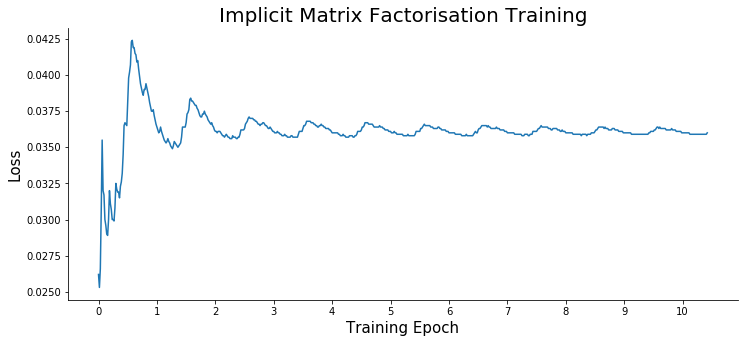

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(range(len(results)), results)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)  
    ax.spines[spine].set_visible(False)
ax.set_ylabel("Loss", rotation=90, size=15)
ax.set_xlabel("Training Epoch", size=15)
ax.set_title("Implicit Matrix Factorisation Training", size=20)
plt.xticks([64*i for i in range(11)], labels=range(11))
""

Let's save the embedding to text. 

In [ ]:
fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/Wimp_1.txt", "w") as f:
    for l in W:
        f.write(",".join([str(i) for i in row])+"\n")

****
# Embedding Results

Here let's test some of the embeddings. First let's load them up.

In [ ]:
word2vec = Word2VecModel.load("gs://fin-bucket/nwe/w2v_1")

fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/Wexp_1.txt", "r") as f:
    explicit = np.genfromtxt(f, delimiter=",", dtype=int)
    
fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/Wimp_1.txt", "r") as f:
    implicit = np.genfromtxt(f, delimiter=",", dtype=int)

fs = gcsfs.GCSFileSystem(project="ST446-project-1", token="cloud")
with fs.open("gs://fin-bucket/SGNS/w2i_1.txt", "r") as f:
    w2i = np.genfromtxt(f, delimiter=",", dtype=int)

Now let's define some functions that will allow us to check some of the embeddings.

In [ ]:
def cossim(a, b, norma=None):
    # compute cosine similarity
    if norma is None:
        norma = np.linalg.norm(a)
    return np.dot(a, b) / (norma * np.linalg.norm(b))

def get_n_similar(word, n, W):
    
    # Find n most similar words in W.
    
    # get the embedded vector for word and compute its norm
    w = W[w2i.index(word)]
    normv = np.linalg.norm(w)
   
    # instantiate lists to hold the indices of top n closest
    indices = [-1] * n
    cossims = [-np.inf] * n
    cut = -np.inf
    
    # loop through embedded vectors
    for i, v in enumerate(W):
        c = cossim(w, v, normv)
        # if cossim is greater than the cutoff (but is not the same word)...
        if 1 > c > cut:
            # insert i, c into the index and cossims lists
            j = bisect_left(cossims, c)
            cossims.insert(j, c)
            cossims.pop(0)
            indices.insert(j, i)
            indices.pop(0)
            cut = cossims[0]
    # return top n converted back to words
    return [(w2i[i], c) for i, c in zip(indices, cossims)]

get_n_similar("girl", 3, implicit)

[('ash', 0.8485072834), ('shoot', 0.7395426211), ('serbia', 0.7259330585)]

In [ ]:
test_words = ["football", "seven", "king", "manchester"]

print("Most similar words:")
print("              |   word2vec   |   explicit   |   implicit   |")
print("--------------+--------------+--------------+--------------+")
for word in test_words:
    print("\n".join([f"{w:^14}|{w2v:^14}|{exp:^14}|{imp:^14}|" for w, w2v, exp, imp in 
                    zip(["", word, ""],
                        get_n_similar(word, 3, word2vec),
                        get_n_similar(word, 3, implicit),
                        get_n_similar(word, 3, explicit)
                       )
                    ]))
    print("--------------+--------------+--------------+--------------+")


Most similar words:
              |   word2vec   |   explicit   |   implicit   |
--------------+--------------+--------------+--------------+
              |   baseball   |   stadium    |    happy     |
   football   |    rugby     |    beach     |    sandal    |
              |   stadium    |   baseball   |    lemon     |
--------------+--------------+--------------+--------------+
              |    eight     |     cafe     |   computer   |
    seven     |     nine     |     nine     |    paint     |
              |     week     |    spain     |     walk     |
--------------+--------------+--------------+--------------+
              |    queen     |    court     |    center    |
     king     |    prince    |    royal     |   district   |
              |     lord     |    prince    |    maple     |
--------------+--------------+--------------+--------------+
              |    london    |    london    |    recent    |
  manchester  |    leeds     |    north     | declaration  |
   

The word2vec embeddings produce similarities that one might expect. The explicit embedding is not far off and even has some of the same words come up as the word2vec. As we might have guess from the loss the implicit embeddings come up with some nonsensical similarities.